In [251]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [252]:
book_img = cv2.imread('cv_cover.jpg', cv2.IMREAD_GRAYSCALE)#lazem grayscale 3shan feature detection
#print(book_img.shape)#
cap = cv2.VideoCapture('book.mov')
ret, frame = cap.read()#read gets the first frame and ret is just a flag to check if successful
cap.release()

if ret:
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)#lazem grayscale 3shan feature detection
else:
    raise ValueError("Error, Couldnt read from video.")

sift = cv2.SIFT_create()
#sift. to get keypoints and their descriptors
keypoints1, descriptors1 = sift.detectAndCompute(book_img, None)
keypoints2, descriptors2 = sift.detectAndCompute(frame_gray, None)



In [253]:
#brute force matcher takes every descriptor in img and compares it to every descriptor in the other img and returns the best match
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)#k=2 means it will return the 2 best matches for each descriptor
#y3ni lkol descriptor fe img1 2 matches fe img2
#matches is a list of lists

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if (m.distance/n.distance) < 0.75:
        good_matches.append(m)

#Take the top 50 good matches
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]


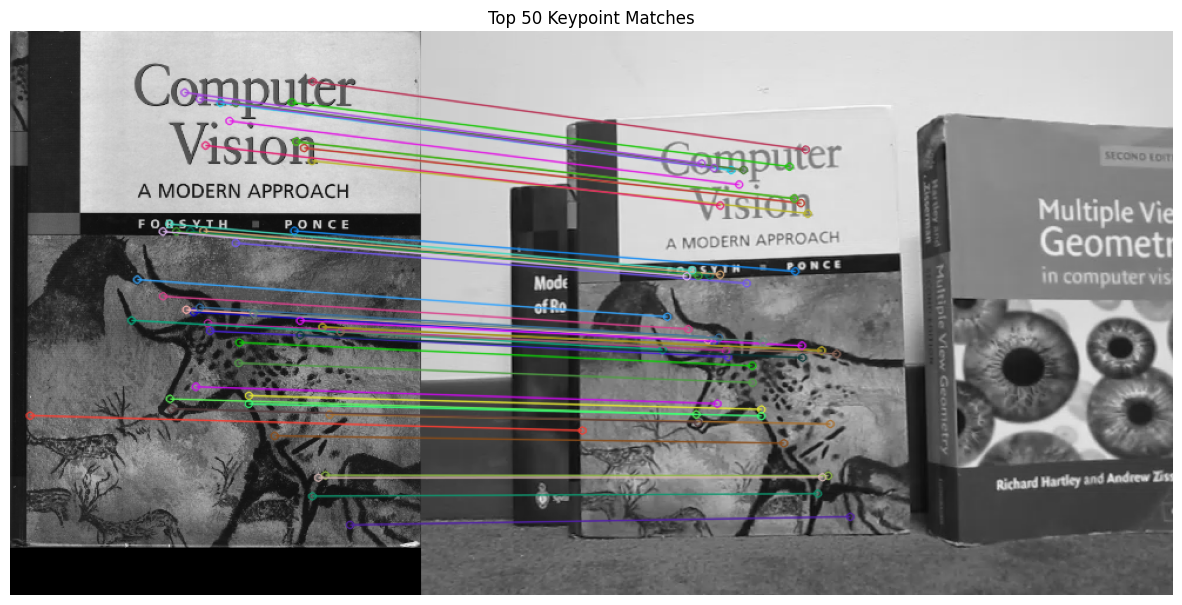

In [254]:
matched_img = cv2.drawMatches(book_img, keypoints1, frame_gray, keypoints2, good_matches, None, flags=2)

plt.figure(figsize=(15, 10))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 Keypoint Matches")
plt.axis('off')
plt.show()


In [ ]:
def compute_homography(src_pts, dst_pts):
    
    #src_pts: List or array of (x, y) points in the first image
    #dst_pts: Corresponding list or array of (x', y') points in the second image

    if len(src_pts) < 4:
        raise ValueError("Need at least 4 point correspondences.")

    A = []
    for (x, y), (x_prime, y_prime) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])

    A = np.array(A)
    b = np.array(dst_pts).reshape(-1)# Flatten the dst_pts array to make it a 1D array
    # print("A shape:", A.shape)
    # print("b shape:", b.shape)
    # Solve Ah = b
    h = np.linalg.lstsq(A, b, rcond=None)[0]# Get the least-squares solution
    #print("Homography coefficients:", h)

    H = np.append(h, 1).reshape((3, 3))#make h33 = 1 and reshape it to 3x3 matrix
    return H


def apply_homography(H, points):
    #Apply the homography matrix to the points.

    points_hom = np.hstack([points, np.ones((len(points), 1))])  # Convert to homogeneous coordinates [x y 1]
    transformed = (H @ points_hom.T).T  # Matrix multiplication to apply the homography

    # Convert back to Cartesian coordinates(2D) by dividing by the last coordinate
    transformed /= transformed[:, 2][:, np.newaxis]
    return transformed[:, :2]## Keep only the x and y coordinates

def draw_projected_points(original_img, projected_pts, actual_pts=None, title="Projected Points"):
    """
    Draws the projected points on the image.

    Args:
        original_img: The image on which to draw (e.g., frame from video).
        projected_pts: Points mapped using the homography.
        actual_pts: Optional ground truth points (to compare).
        title: Title of the plot.
    """
    img_display = original_img.copy()
    if len(img_display.shape) == 2:
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)

    for pt in projected_pts:
        x, y = int(pt[0]), int(pt[1])
        cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)  # red dot for projected point

    if actual_pts is not None:
        for pt in actual_pts:
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(img_display, (x, y), 5, (0, 255, 0), 2)  # green circle for actual point

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [256]:
# # Get points from matches
# src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
# dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# # Compute homography and apply
# H = compute_homography(src_pts, dst_pts)
# projected_pts = apply_homography(H, src_pts)

# # Visualize projected vs actual points on frame
# draw_projected_points(frame, projected_pts, actual_pts=dst_pts, title="Projected vs Actual Points")


A shape: (100, 8)
b shape: (100,)


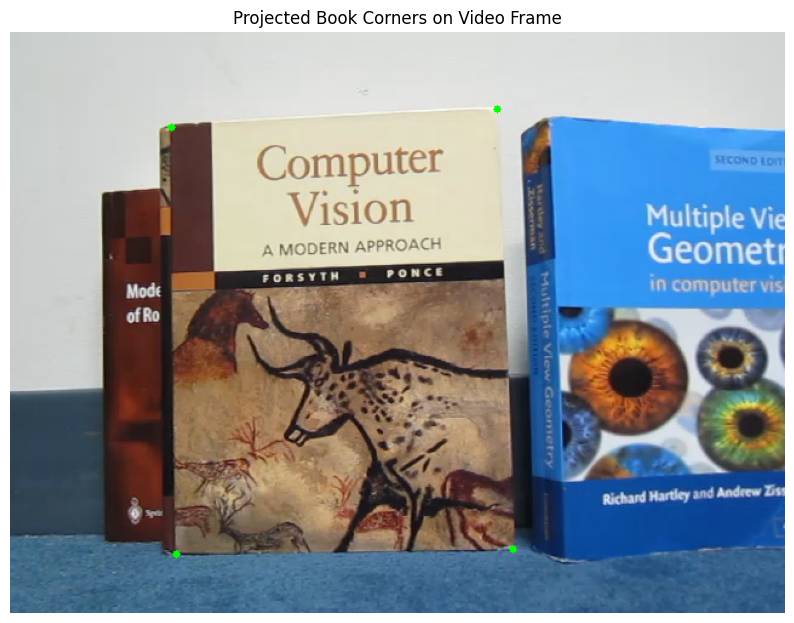

In [257]:
#middle 1 is just an extra axis OpenCV uses internally
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# reshape it to look like this [[x1,y1],[x2,y2]].... flat array of 2D points
H = compute_homography(src_pts.reshape(-1, 2), dst_pts.reshape(-1, 2))

h, w = book_img.shape
# book_corners = np.array([
#     [18, 4],
#     [w - 1, 3],
#     [w - 3, h - 3],
#     [16, h - 3]
# ], dtype=np.float32)
book_corners = np.array([
    [18, 4],
    [w - 1, 3],
    [w - 3, h - 3],
    [16, h - 3]
], dtype=np.float32)

book_corners_proj = apply_homography(H, book_corners)
book_corners_proj_int = np.int32(book_corners_proj)#Convert to integer coordinates only for drawing

frame_with_corners = frame.copy()
# cv2.polylines(frame_with_corners, [book_corners_proj_int], isClosed=True, color=(0, 0, 255), thickness=3)

# Draw each corner
for pt in book_corners_proj_int:
    cv2.circle(frame_with_corners, tuple(pt), radius=3, color=(0, 255, 0), thickness=-1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame_with_corners, cv2.COLOR_BGR2RGB))
plt.title("Projected Book Corners on Video Frame")
plt.axis('off')
plt.show()

Cropped frame shape: 480 640
Frame shape: 360 640
Frame center: 320 180
Crop dimensions: 333 434
Crop coordinates: 154 0 486 360
Cropped frame shapesdfs: (360, 332, 3)
Cropped frame shapedadasdasdasdasd: (434, 333, 3)
A shape: (8, 8)
b shape: (8,)
Cropped and resized frame shape: (480, 640, 3)


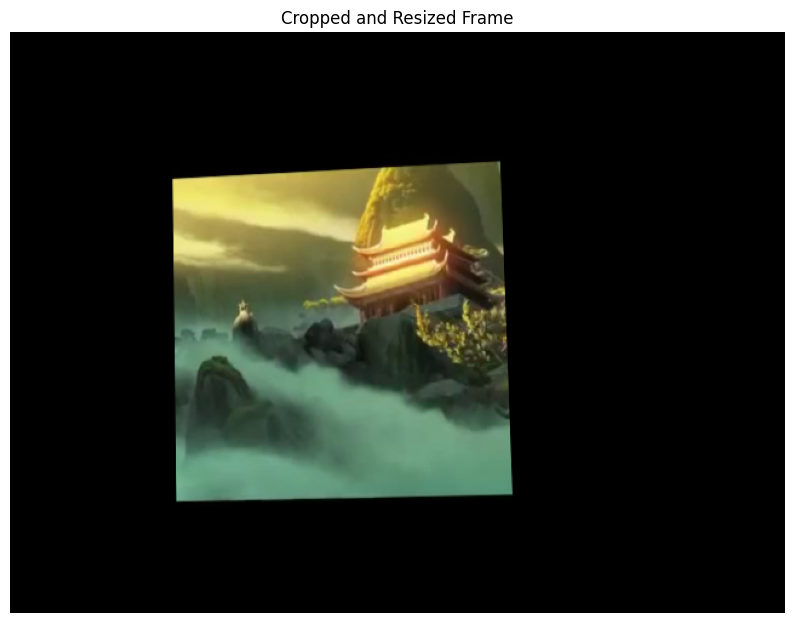

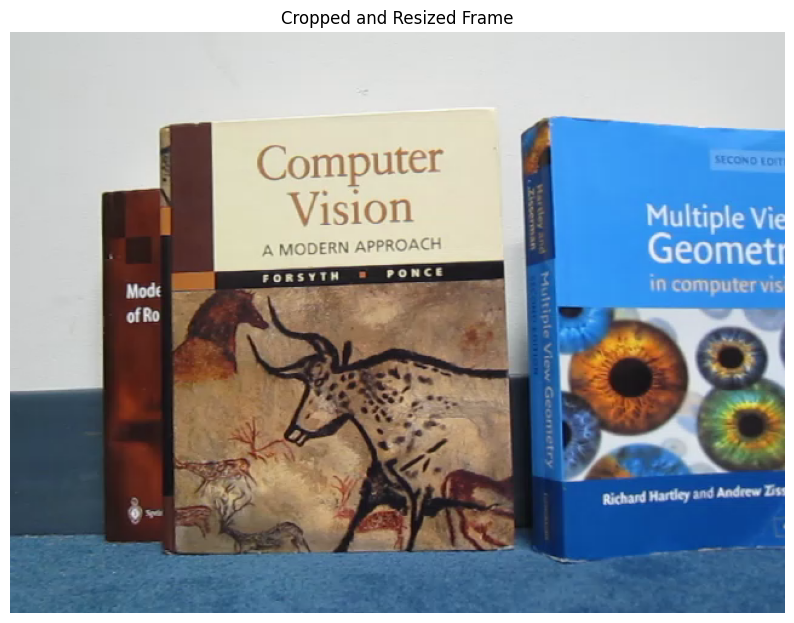

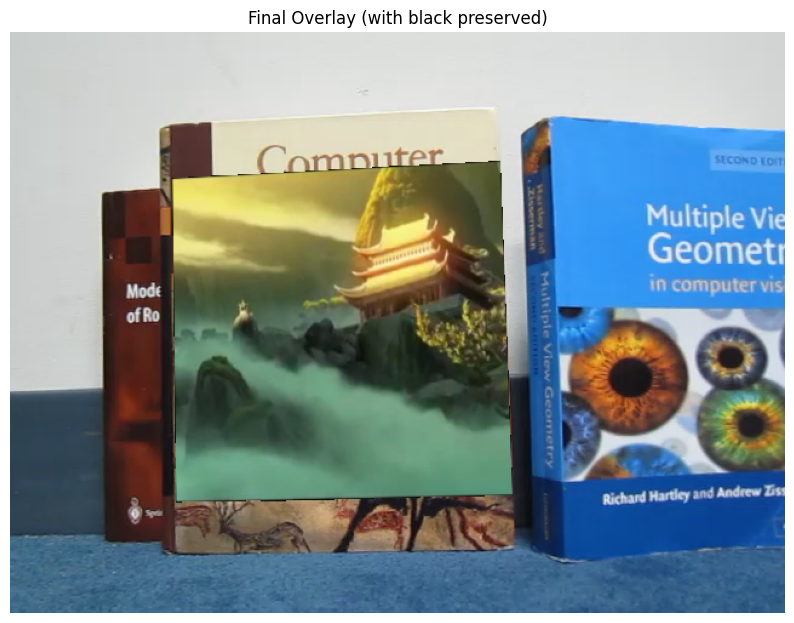

In [258]:
# Load the video
cap = cv2.VideoCapture('ar_source.mov')

# Read the first frame
ret, v_frame = cap.read()

if not ret:
    print("Failed to read video frame.")
    exit()

# height,width,_=frame.shape
# print("Frame shape:", height, width)
book_corners_int = np.int32(book_corners)


# Get the x_min and x_max from the projected corners (left and right bounds)
x_min, y_min = np.min(book_corners_int, axis=0)
x_max, y_max = np.max(book_corners_int, axis=0)

# Crop the frame: Here, we crop from the left (x_min) and right (x_max)
# Adjust the y_min and y_max values if you want a vertical crop as well (currently only horizontal crop)
meowhhhh,meowwwww=frame.shape[:2]
print("Cropped frame shape:", meowhhhh, meowwwww)

frame_height, frame_width = v_frame.shape[:2]
print("Frame shape:", frame_height, frame_width)

center_x, center_y = frame_width // 2, frame_height // 2
print("Frame center:", center_x, center_y)

# Optionally, resize the cropped frame to match the book's aspect ratio (if needed)
crop_width = x_max - x_min
crop_height = y_max - y_min 
print("Crop dimensions:", crop_width, crop_height)

x_start = center_x - crop_width // 2
x_end = center_x + crop_width // 2
y_start = center_y - crop_height // 2
y_end = center_y + crop_height // 2

x_start = max(0, x_start)
x_end = min(frame_width, x_end)
y_start = max(0, y_start)
y_end = min(frame_height, y_end)

print("Crop coordinates:", x_start, y_start, x_end, y_end)


cropped_frame = v_frame[y_start:y_end, x_start:x_end]
print("Cropped frame shapesdfs:", cropped_frame.shape)
cropped_frame = cv2.resize(cropped_frame, (crop_width, crop_height))
print("Cropped frame shapedadasdasdasdasd:", cropped_frame.shape)


hpanda, wpanda = cropped_frame.shape[:2]
src_pts = np.float32([[0, 0], [wpanda - 1, 0], [wpanda - 1, hpanda - 1], [0, hpanda - 1]])

# Destination points (where you want to warp this image into)
dst_pts = book_corners_proj.astype(np.float32)

# Recompute homography for this cropped image
H_crop_to_book = compute_homography(src_pts, dst_pts)



warped_cropped = cv2.warpPerspective(cropped_frame, H_crop_to_book, (meowwwww, meowhhhh))


print("Cropped and resized frame shape:", warped_cropped.shape)
# Display the cropped and resized frame
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped_cropped, cv2.COLOR_BGR2RGB))
plt.title("Cropped and Resized Frame")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Cropped and Resized Frame")
plt.axis('off')
plt.show()

# Create a mask of non-black pixels in warped_cropped
gray_warp = cv2.cvtColor(warped_cropped, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_warp, 10, 255, cv2.THRESH_BINARY)  # mask where pixel intensity > 10
mask_inv = cv2.bitwise_not(mask)

# Convert mask to 3-channel to match image shape
mask_3ch = cv2.merge([mask, mask, mask])
mask_inv_3ch = cv2.merge([mask_inv, mask_inv, mask_inv])

# Mask out the region in the original frame where warped_cropped will go
frame_bg = cv2.bitwise_and(frame, mask_inv_3ch)

# Take only the non-black parts from warped_cropped
overlay_fg = cv2.bitwise_and(warped_cropped, mask_3ch)

# Combine the background and foreground
final_overlay = cv2.add(frame_bg, overlay_fg)


plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
plt.title("Final Overlay (with black preserved)")
plt.axis('off')
plt.show()



# Release the video capture object
cap.release()